In [1]:
import pandas as pd
import os
from datetime import datetime as dt
import wrangle
import re
from pandas.tseries.holiday import USFederalHolidayCalendar
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
plt.rcParams["figure.figsize"] = (12,10)
alpha =.05

### Acquire 

In [2]:
df = wrangle.get_combined_df()
df.head()

,ercot_load,dow,is_weekday,is_obs_holiday,hs_temp,hs_feelslike,hs_dew,hs_humidity,hs_precip,hs_windgust,...,vc_precip,vc_windgust,vc_windspeed,vc_winddir,vc_sealevelpressure,vc_cloudcover,vc_visibility,vc_solarradiation,vc_solarenergy,vc_uvindex
datetime,,,,,,,,,,,,,,,,,,,,,
2010-01-01 00:00:00-06:00,7931.241900,Friday,1,1,47.3,41.2,43.2,85.37,0.0,27.5,...,0.0,24.2,16.1,360.0,1027.7,98.7,9.9,0.0,NaN,0
2010-01-01 01:00:00-06:00,7775.456846,Friday,1,1,46.8,39.9,41.4,81.38,0.0,24.2,...,0.0,26.5,15.1,350.0,1028.1,98.6,9.9,0.0,NaN,0
2010-01-01 02:00:00-06:00,7704.815982,Friday,1,1,45.0,37.1,39.6,81.24,0.0,28.9,...,0.0,31.1,21.9,350.0,1028.8,98.6,9.9,0.0,NaN,0
2010-01-01 03:00:00-06:00,7650.575724,Friday,1,1,45.0,38.3,39.3,80.35,0.0,26.4,...,0.0,25.4,17.2,350.0,1028.9,98.7,9.9,0.0,NaN,0
2010-01-01 04:00:00-06:00,7666.708317,Friday,1,1,45.0,37.7,37.8,75.72,0.0,NaN,...,0.0,32.3,24.2,10.0,1028.0,27.7,9.9,0.0,NaN,0


### Prepare

In [3]:
df['hour'] = df.index.strftime('%H')

In [4]:
# # split data into train and test datasets, train 2010-2017 and test 2018-2022

train = df[:'2017']
test = df['2018':]

In [49]:
train.describe()

,ercot_load,is_weekday,is_obs_holiday,hs_temp,hs_feelslike,hs_dew,hs_humidity,hs_precip,hs_windgust,hs_windspeed,...,vc_precip,vc_windgust,vc_windspeed,vc_winddir,vc_sealevelpressure,vc_cloudcover,vc_visibility,vc_solarradiation,vc_solarenergy,vc_uvindex
count,70128.000000,70128.000000,70128.000000,70128.000000,70128.000000,70128.000000,70128.000000,70128.000000,13765.000000,70128.000000,...,70128.000000,20699.000000,70128.000000,70128.000000,70062.000000,70128.000000,70128.000000,70128.000000,37860.000000,70128.000000
mean,11061.473113,0.713895,0.027379,71.252129,72.399886,59.365617,69.410485,0.003719,22.458896,7.962128,...,0.003252,23.027924,9.095980,151.728505,1016.142886,39.257454,8.612835,216.765616,1.444847,2.157854
std,2590.744768,0.451942,0.163185,13.889405,16.751161,15.251368,20.057911,0.038717,5.194451,4.895214,...,0.033001,6.841198,5.548535,102.409535,5.734598,41.848493,2.383467,293.859915,1.055741,2.951228
min,6293.573072,0.000000,0.000000,20.300000,4.300000,1.800000,10.050000,0.000000,11.400000,0.000000,...,0.000000,0.000000,0.000000,0.000000,993.900000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9191.267527,0.000000,0.000000,62.700000,62.700000,49.800000,54.470000,0.000000,18.300000,4.900000,...,0.000000,19.500000,5.100000,73.000000,1012.500000,0.000000,8.200000,0.000000,0.500000,0.000000
50%,10466.756159,1.000000,0.000000,73.500000,73.500000,64.500000,73.160000,0.000000,21.600000,7.700000,...,0.000000,22.900000,8.100000,149.000000,1015.400000,25.900000,9.900000,8.900000,1.400000,0.000000
75%,12476.718905,1.000000,0.000000,80.700000,85.200000,71.700000,86.620000,0.000000,25.300000,10.900000,...,0.000000,26.400000,12.700000,189.000000,1019.100000,88.300000,9.900000,415.800000,2.300000,4.000000
max,20100.758612,1.000000,1.000000,110.400000,115.900000,80.300000,100.000000,1.880000,83.900000,36.800000,...,1.850000,161.100000,53.100000,360.000000,1042.500000,100.000000,74.200000,1079.000000,3.900000,10.000000


In [6]:
train.tail(1)

,ercot_load,dow,is_weekday,is_obs_holiday,hs_temp,hs_feelslike,hs_dew,hs_humidity,hs_precip,hs_windgust,...,vc_windgust,vc_windspeed,vc_winddir,vc_sealevelpressure,vc_cloudcover,vc_visibility,vc_solarradiation,vc_solarenergy,vc_uvindex,hour
datetime,,,,,,,,,,,,,,,,,,,,,
2017-12-31 23:00:00-06:00,11579.853459,Sunday,0,0,40.8,33.0,30.2,65.5,0.0,25.7,...,26.1,14.9,360.0,1033.7,95.6,9.9,0.0,0.0,0,23


In [7]:
test.head(1)

,ercot_load,dow,is_weekday,is_obs_holiday,hs_temp,hs_feelslike,hs_dew,hs_humidity,hs_precip,hs_windgust,...,vc_windgust,vc_windspeed,vc_winddir,vc_sealevelpressure,vc_cloudcover,vc_visibility,vc_solarradiation,vc_solarenergy,vc_uvindex,hour
datetime,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00-06:00,11452.163689,Monday,1,1,38.9,29.9,28.4,65.69,0.0,26.4,...,25.8,16.0,10.0,1033.9,98.8,9.9,0.0,0.0,0,00


In [8]:
test.tail(1)

,ercot_load,dow,is_weekday,is_obs_holiday,hs_temp,hs_feelslike,hs_dew,hs_humidity,hs_precip,hs_windgust,...,vc_windgust,vc_windspeed,vc_winddir,vc_sealevelpressure,vc_cloudcover,vc_visibility,vc_solarradiation,vc_solarenergy,vc_uvindex,hour
datetime,,,,,,,,,,,,,,,,,,,,,
2022-06-30 23:00:00-05:00,14065.386852,Thursday,1,0,77.2,77.2,73.4,88.06,0.0,10.5,...,13.9,7.0,79.0,1014.0,0.4,9.9,0.0,NaN,0,23


### Explore

### Initial look at the target variable

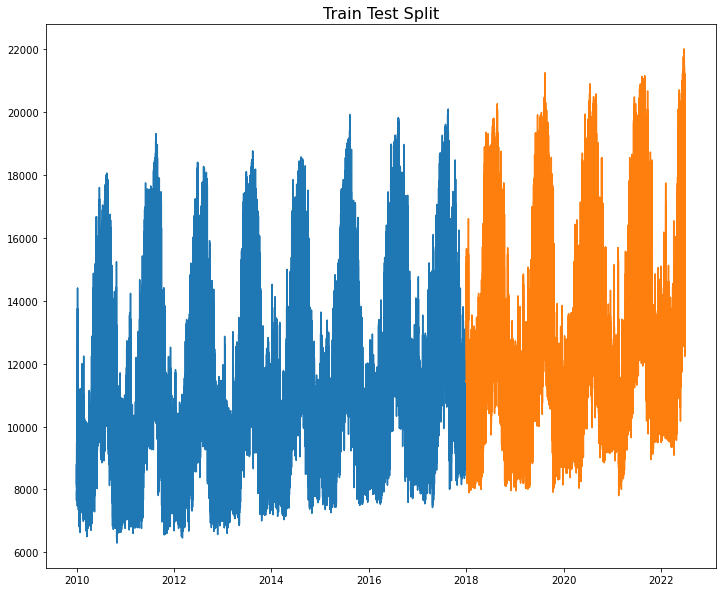

In [9]:
plt.plot(train.index, train.ercot_load)
plt.plot(test.index, test.ercot_load)
plt.title('Train Test Split', fontsize = 16)
plt.show()

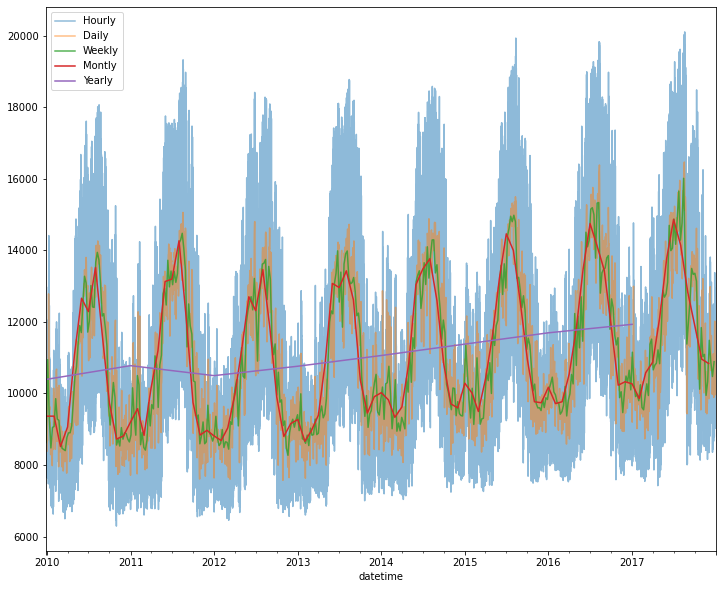

In [10]:
train.resample('H').ercot_load.mean().plot(alpha=.5, label='Hourly')
train.resample('D').ercot_load.mean().plot(alpha=.5, label='Daily')
train.resample('W').ercot_load.mean().plot(alpha=.8, label='Weekly')
train.resample('M').ercot_load.mean().plot(label='Montly')
train.resample('Y').ercot_load.mean().plot(label='Yearly')
plt.legend()
plt.show()

**Notes:** Seasonality is visible, with an increase in ercot load over time.

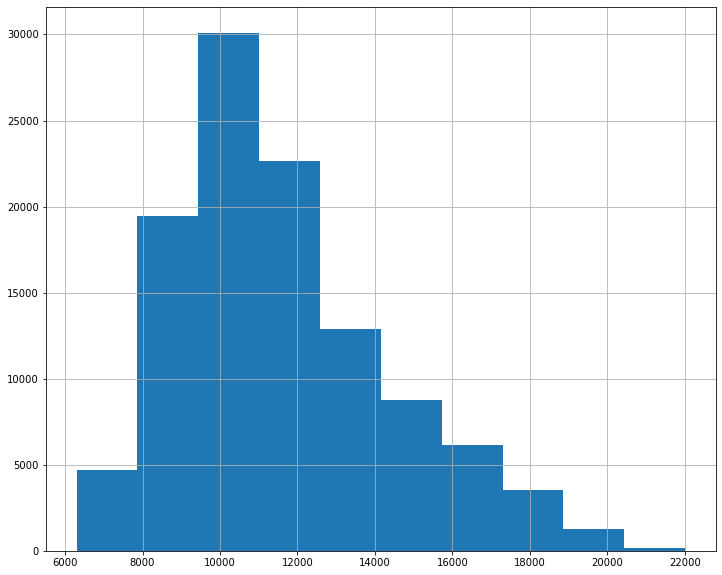

In [11]:
df.ercot_load.hist()
plt.show()

### Inital Hypotheses:
   - There is a relationship between the day of the week and energy demand.
   - There is a relationship between the time of day and energy demand.
   - There is a relationship between holidays and energy demand.

### Day of the Week:

In [30]:
# ax = train.groupby(train.dow).ercot_load.mean().plot.bar(width=.9, ec='black')
# plt.xticks(rotation=0)
# ax.set(title='Average Load by Day of the Week', xlabel='', ylabel='Megawatts')
# plt.show()

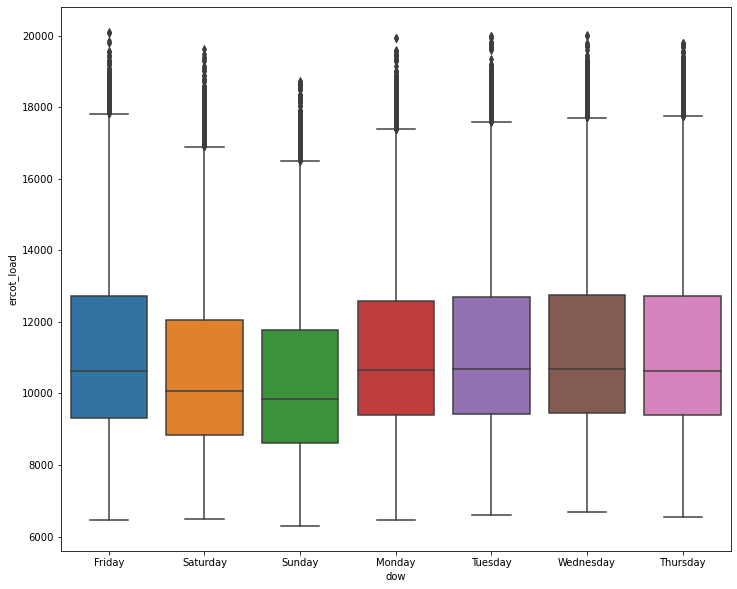

In [13]:
sns.boxplot(x = 'dow', y = 'ercot_load', data=train) 
plt.show()

In [29]:
# train.groupby([train.index.year, train.index.dayofweek]).ercot_load.mean().unstack(0).plot(title='Yearly view of Ercot Load by Day of the Week')
# plt.show()

### Hypothesis Testing
 - What hypothesis testing is viable on time series data?


In [15]:
monday = train[train.dow=='Monday'].ercot_load
tuesday = train[train.dow=='Tuesday'].ercot_load
wednesday = train[train.dow=='Wednesday'].ercot_load
thursday = train[train.dow=='Thursday'].ercot_load
friday = train[train.dow=='Friday'].ercot_load
saturday = train[train.dow=='Saturday'].ercot_load
sunday = train[train.dow=='Sunday'].ercot_load

#### Perform Levene's Test for Equal Variance
- Null Hypothesis: Variance is equal between the days of the week.
- Alternative Hypothesis: Variance is not equal between the days of the week.

In [16]:
stat, p = stats.levene(monday,tuesday,wednesday,thursday,friday,saturday,sunday)

In [17]:
p

4.198650539667989e-10

In [18]:
if p < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis.


#### Perform Kruskal- Wallis Test to determine significant difference between ercot load and the day of the week.
 - Kruskal-Wallis test performed as variance is not equal.
 
- Null Hypothesis: The mean of ercot load is equal on every day of the week.
- Alternative Hypothesis: The mean of ercot load is not equal for each day of the week.

In [19]:
stat, p = stats.kruskal(monday,tuesday,wednesday,thursday,friday,saturday,sunday)
stat, p

(1338.202452707832, 5.811407864502267e-286)

In [20]:
if p < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis.


### Time of day:

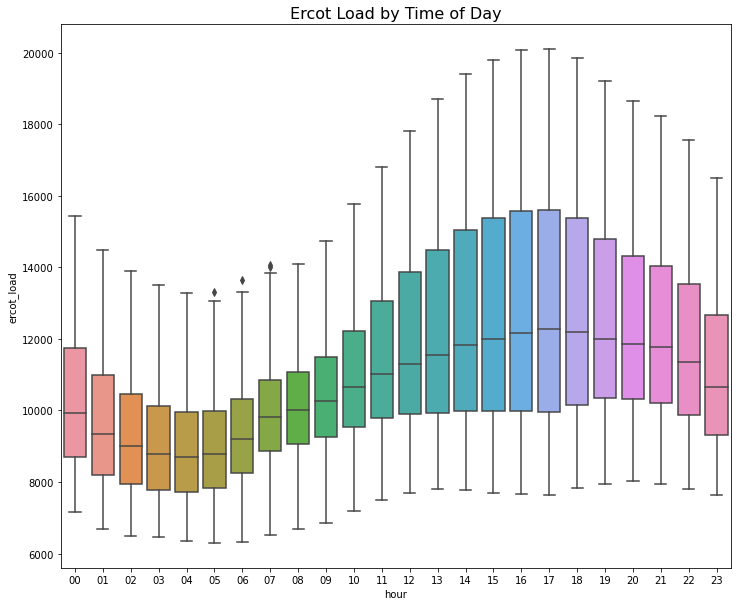

In [21]:
sns.boxplot(x = 'hour', y = 'ercot_load', data=train) 
plt.title('Ercot Load by Time of Day', fontsize=16)
plt.show()

**Notes:** There is a visible change in ercot load by hour, with a lull in the early hours of the day and an expected increase in afternoon. I expect this would be correlated with max temperatures. Another note: the hours of 05-07 have outliers on the side of increased ercot load.

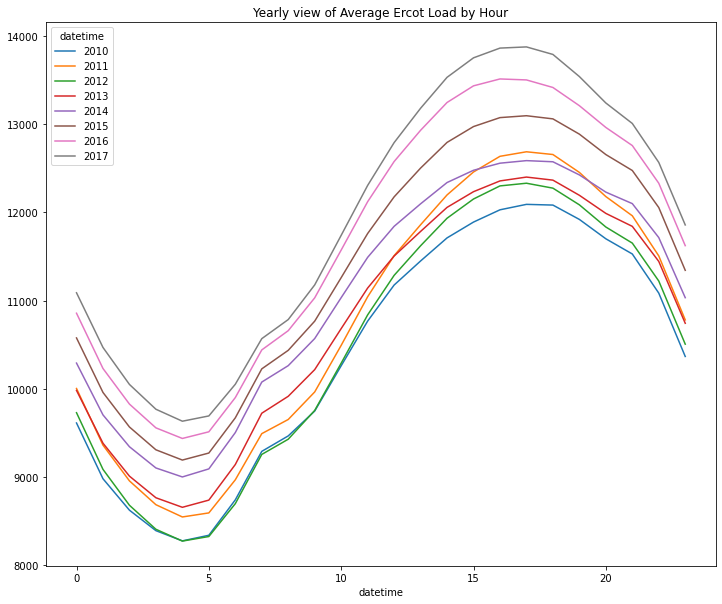

In [73]:
train.groupby([train.index.year, train.index.hour]).ercot_load.mean().unstack(0).plot(title='Yearly view of Average Ercot Load by Hour')
plt.show()

**Notes:** This visualization shows a similiar pattern that shown above, but also breaks out the time of day by year. We can see that in the early years, the ercot load was lower and has increased as time has passed, while still following the same daily trends.

### Hypothesis Testing

#### Perform Levene's Test for Equal Variance
- Null Hypothesis: Variance is equal between the hours of the day.
- Alternative Hypothesis: Variance is not equal between the hours of the day.

In [61]:
zero = train[train.hour=='00'].ercot_load
one = train[train.hour=='01'].ercot_load
two = train[train.hour=='02'].ercot_load
three = train[train.hour=='03'].ercot_load
four = train[train.hour=='04'].ercot_load
five = train[train.hour=='05'].ercot_load
six = train[train.hour=='06'].ercot_load
seven = train[train.hour=='07'].ercot_load
eight = train[train.hour=='08'].ercot_load
nine = train[train.hour=='09'].ercot_load
ten = train[train.hour=='10'].ercot_load
eleven = train[train.hour=='11'].ercot_load
tweleve = train[train.hour=='12'].ercot_load
thirteen = train[train.hour=='13'].ercot_load
fourteen = train[train.hour=='14'].ercot_load
fifteen = train[train.hour=='15'].ercot_load
sixteen = train[train.hour=='16'].ercot_load
seventeen = train[train.hour=='17'].ercot_load
eighteen = train[train.hour=='18'].ercot_load
nineteen = train[train.hour=='19'].ercot_load
twenty = train[train.hour=='20'].ercot_load
twentyone = train[train.hour=='21'].ercot_load
twentytwo = train[train.hour=='22'].ercot_load
twentythree = train[train.hour=='23'].ercot_load

In [67]:
stat, p = stats.levene(zero, one, two, three, four, five, six, seven, eight, nine, ten, eleven, tweleve, thirteen, fourteen, fifteen, sixteen, seventeen, eighteen, nineteen, twenty, twentyone, twentytwo, twentythree)

In [68]:
stat, p

(647.3097281228604, 0.0)

In [69]:
if p < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis.


#### Perform Kruskal- Wallis Test to determine significant difference between ercot load and the day of the week.
 - Kruskal-Wallis test performed as variance is not equal.
 
- Null Hypothesis: The mean of ercot load is equal during every hour of the day.
- Alternative Hypothesis: The mean of ercot load is not equal during every hour of the day.

In [70]:
stat, p = stats.kruskal(zero, one, two, three, four, five, six, seven, eight, nine, ten, eleven, tweleve, thirteen, fourteen, fifteen, sixteen, seventeen, eighteen, nineteen, twenty, twentyone, twentytwo, twentythree)
stat, p

(20137.722180245037, 0.0)

In [71]:
if p < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis.


### Holidays

In [33]:
train.is_obs_holiday.value_counts()

0    68208
1     1920
Name: is_obs_holiday, dtype: int64

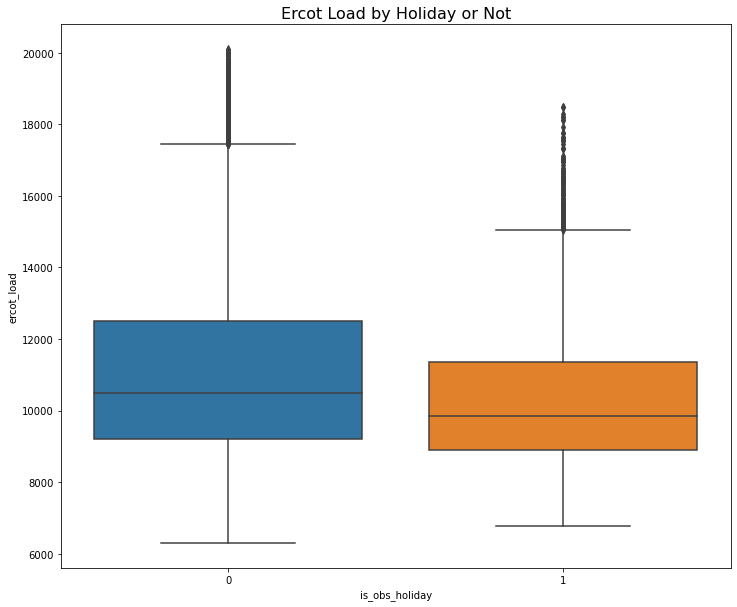

In [44]:
sns.boxplot(x = 'is_obs_holiday', y = 'ercot_load', data=train) 
plt.title('Ercot Load by Holiday or Not', fontsize=16)
plt.show()

**Notes:** Median ercot load value is less on holidays than non-holidays.

In [36]:
holidays = train[train.is_obs_holiday==1]

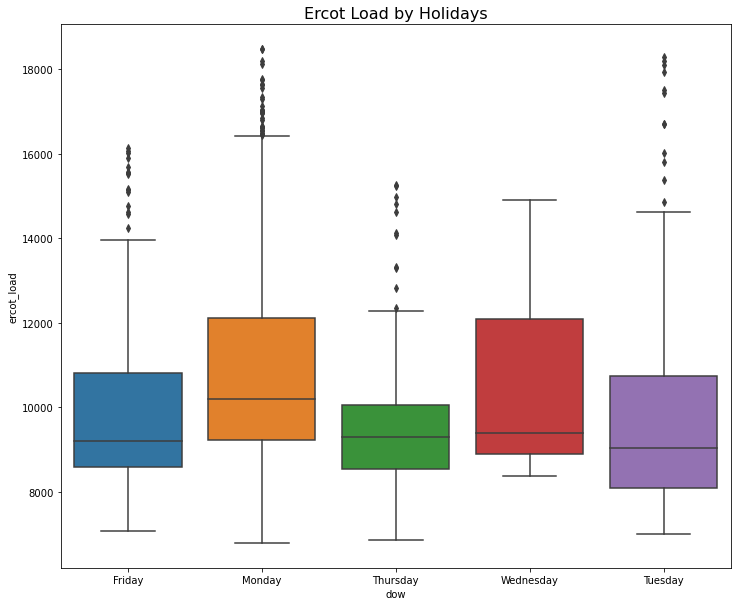

In [47]:
sns.boxplot(x = 'dow', y = 'ercot_load', data=holidays) 
plt.title('Ercot Load by Holidays', fontsize=16)
plt.show()

In [39]:
holidays

,ercot_load,dow,is_weekday,is_obs_holiday,hs_temp,hs_feelslike,hs_dew,hs_humidity,hs_precip,hs_windgust,...,vc_windgust,vc_windspeed,vc_winddir,vc_sealevelpressure,vc_cloudcover,vc_visibility,vc_solarradiation,vc_solarenergy,vc_uvindex,hour
datetime,,,,,,,,,,,,,,,,,,,,,
2010-01-01 00:00:00-06:00,7931.241900,Friday,1,1,47.3,41.2,43.2,85.37,0.0,27.5,...,24.2,16.1,360.0,1027.7,98.7,9.9,0.0,NaN,0,00
2010-01-01 01:00:00-06:00,7775.456846,Friday,1,1,46.8,39.9,41.4,81.38,0.0,24.2,...,26.5,15.1,350.0,1028.1,98.6,9.9,0.0,NaN,0,01
2010-01-01 02:00:00-06:00,7704.815982,Friday,1,1,45.0,37.1,39.6,81.24,0.0,28.9,...,31.1,21.9,350.0,1028.8,98.6,9.9,0.0,NaN,0,02
2010-01-01 03:00:00-06:00,7650.575724,Friday,1,1,45.0,38.3,39.3,80.35,0.0,26.4,...,25.4,17.2,350.0,1028.9,98.7,9.9,0.0,NaN,0,03
2010-01-01 04:00:00-06:00,7666.708317,Friday,1,1,45.0,37.7,37.8,75.72,0.0,NaN,...,32.3,24.2,10.0,1028.0,27.7,9.9,0.0,NaN,0,04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-25 19:00:00-06:00,10393.319286,Monday,1,1,49.9,45.7,40.0,68.55,0.0,17.2,...,NaN,7.4,98.0,1023.1,98.7,9.9,0.0,NaN,0,19
2017-12-25 20:00:00-06:00,10417.171460,Monday,1,1,51.0,51.0,40.5,67.36,0.0,NaN,...,NaN,9.3,96.0,1022.9,91.7,9.9,0.0,NaN,0,20
2017-12-25 21:00:00-06:00,10358.938895,Monday,1,1,51.6,51.6,39.5,63.20,0.0,NaN,...,NaN,9.2,60.0,1022.8,98.3,9.9,0.0,NaN,0,21
